In [2]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
BATCH_SIZE = 64
EPOCHS = 10
LSTM_NODES =256
NUM_SENTENCES = 200000
MAX_SENTENCE_LENGTH = 20
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [4]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []


count = 0
for line in open('deu.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output = line.rstrip().split('\t')[0:2]
    
    if len(input_sentence) < MAX_SENTENCE_LENGTH:
        output_sentence = output
        output_sentence_input = output
    else:
        continue

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)
    



print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 36779
num samples output: 36779
num samples output input: 36779


In [9]:
import re
import string

exclude = set(string.punctuation)

for x in range(len(input_sentences)):
    input_sentences[x] = input_sentences[x].lower()
    input_sentences[x] = re.sub("'", '', input_sentences[x])
    input_sentences[x] = re.sub(",", '', input_sentences[x])
    input_sentences[x] = ''.join(ch for ch in input_sentences[x] if ch not in exclude)
    
    
for x in range(len(input_sentences)):
    output_sentences[x] = output_sentences[x].lower()
    output_sentences[x] = re.sub("'", '', output_sentences[x])
    output_sentences[x] = re.sub(",", '', output_sentences[x])
    output_sentences[x] = ''.join(ch for ch in output_sentences[x] if ch not in exclude)
    output_sentences[x] = output_sentences[x] + ' <eos>'
    
    
for x in range(len(input_sentences)):
    output_sentences_inputs[x] = output_sentences_inputs[x].lower()
    output_sentences_inputs[x] = re.sub("'", '', output_sentences_inputs[x])
    output_sentences_inputs[x] = re.sub(",", '', output_sentences_inputs[x])
    output_sentences_inputs[x] = ''.join(ch for ch in output_sentences_inputs[x] if ch not in exclude)
    output_sentences_inputs[x] = '<sos> ' + output_sentences_inputs[x]

input_sentences, test_english = train_test_split(input_sentences, test_size=0.2, random_state=20, shuffle=False)
output_sentences, test_german = train_test_split(output_sentences, test_size=0.2, random_state=20, shuffle=False)
output_sentences_inputs, test_german_input = train_test_split(output_sentences_inputs, test_size=0.2, random_state=20, shuffle=False)


In [19]:
t = 175

print(input_sentences[t])
print(output_sentences[t])
print(output_sentences_inputs[t])

go away
hau ab <eos>
<sos> hau ab


In [21]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 4539
Length of longest sentence in input: 6


In [22]:
# Tokenizing Test Split Input
test_input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

test_max_input_len = max(len(sen) for sen in test_input_integer_seq)
print("Length of longest sentence in input: %g" % test_max_input_len)

Total unique words in the input: 4539
Length of longest sentence in input: 6


In [23]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)
print(len(output_input_integer_seq))

Total unique words in the output: 7202
Length of longest sentence in the output: 11
29423


In [24]:
# Tokenizing Test Split output
test_output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
test_output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

text_word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

test_num_words_output = len(word2idx_outputs) + 1
test_max_out_len = max(len(sen) for sen in test_output_integer_seq)
print("Length of longest sentence in the output: %g" % test_max_out_len)

Total unique words in the output: 7202
Length of longest sentence in the output: 11


In [26]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (29423, 6)
encoder_input_sequences[172]: [  0   0   0   0  24 122]


In [27]:
# Padding Test Split input
test_encoder_input_sequences = pad_sequences(test_input_integer_seq, maxlen=test_max_input_len)
print("encoder_input_sequences.shape:", test_encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", test_encoder_input_sequences[172])

encoder_input_sequences.shape: (29423, 6)
encoder_input_sequences[172]: [  0   0   0   0  24 122]


In [29]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[172]:", decoder_output_sequences[172])

decoder_output_sequences.shape: (29423, 11)
decoder_output_sequences[172]: [ 43   6 109   1   0   0   0   0   0   0   0]


In [30]:
# Padding Test Split output
test_decoder_output_sequences = pad_sequences(test_output_integer_seq, maxlen=test_max_out_len, padding='post')
print("decoder_output_sequences.shape:", test_decoder_output_sequences.shape)
print("decoder_output_sequences[172]:", test_decoder_output_sequences[172])

decoder_output_sequences.shape: (29423, 11)
decoder_output_sequences[172]: [ 43   6 109   1   0   0   0   0   0   0   0]


In [5]:
# print(word2idx_inputs["can"])
# print(word2idx_inputs["ill"])

In [32]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (29423, 11)
decoder_input_sequences[172]: [  2  43   6 109   0   0   0   0   0   0   0]


In [33]:
test_decoder_input_sequences = pad_sequences(test_output_input_integer_seq, maxlen=test_max_out_len, padding='post')
print("decoder_input_sequences.shape:", test_decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", test_decoder_input_sequences[172])

decoder_input_sequences.shape: (29423, 11)
decoder_input_sequences[172]: [  2  43   6 109   0   0   0   0   0   0   0]


In [35]:
from numpy import array
from numpy import asarray
from numpy import zeros

# For saving Glove to Pickle
# embeddings_dictionary = dict()

# glove_file = open('glove.6B.100d.txt', encoding="utf8")

# for line in glove_file:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = asarray(records[1:], dtype='float32')
#     embeddings_dictionary[word] = vector_dimensions
# glove_file.close()

# pickle_dumper_glove = open("save_glove_100d_20092022", "wb")

# pickle.dump(embeddings_dictionary, pickle_dumper_glove)

In [36]:
pickle_loader_glove = open("save_glove_100d_20092022", "rb")

embeddings_dictionary = pickle.load(pickle_loader_glove)

In [37]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [38]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [39]:
decoder_targets_one_hot = np.zeros((
        int(len(input_sentences)),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [40]:
decoder_output_sequences.shape

(29423, 11)

In [41]:
decoder_targets_one_hot.shape

(29423, 11, 7203)

In [42]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [43]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [44]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [45]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [46]:
print(encoder_inputs_placeholder)
print(decoder_inputs_placeholder)
print(decoder_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 11), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 11, 7203), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [47]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

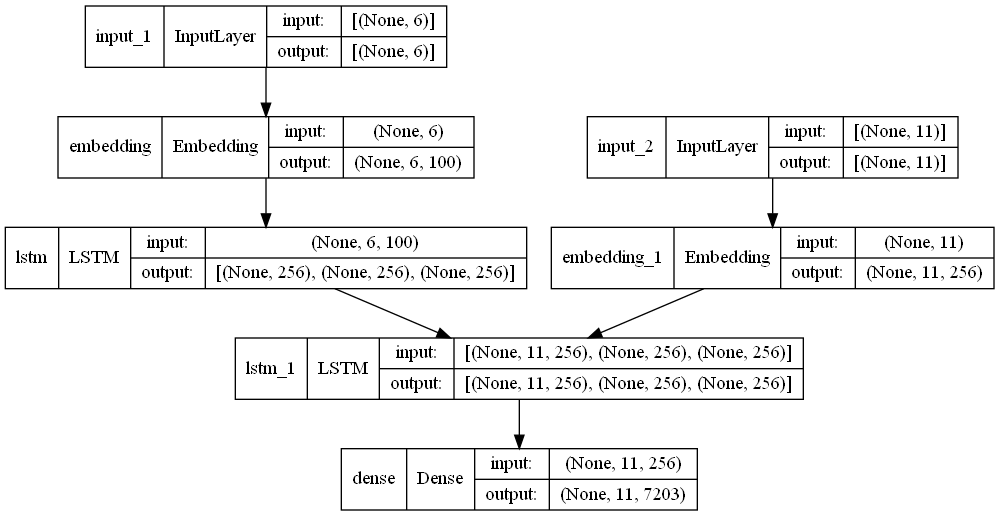

In [49]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='final_work_implementation_data.png', show_shapes=True, show_layer_names=True)


In [50]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/10
460/460 [==============================] - 86s 182ms/step - loss: 1.9399 - accuracy: 0.7209
Epoch 2/10
460/460 [==============================] - 86s 188ms/step - loss: 1.4022 - accuracy: 0.7870
Epoch 3/10
460/460 [==============================] - 87s 190ms/step - loss: 1.1995 - accuracy: 0.8125
Epoch 4/10
460/460 [==============================] - 89s 193ms/step - loss: 1.0700 - accuracy: 0.8304
Epoch 5/10
460/460 [==============================] - 87s 190ms/step - loss: 0.9713 - accuracy: 0.8452
Epoch 6/10
460/460 [==============================] - 94s 204ms/step - loss: 0.8941 - accuracy: 0.8567
Epoch 7/10
460/460 [==============================] - 102s 221ms/step - loss: 0.8339 - accuracy: 0.8665
Epoch 8/10
460/460 [==============================] - 100s 217ms/step - loss: 0.7847 - accuracy: 0.8748
Epoch 9/10
460/460 [==============================] - 103s 223ms/step - loss: 0.7420 - accuracy: 0.8822
Epoch 10/10
460/460 [==============================] - 104s 226ms/step

In [53]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [54]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [55]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [56]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [57]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [58]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [60]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [61]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [62]:
# for i in 
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', i, input_sentences[i])
print('Actual Output:', output_sentences[i])
print('Response:', translation)

-
Input: 10953 tom lost again
Actual Output: tom hat wieder verloren <eos>
Response: tom hat wieder verloren


In [63]:
# for i in 
i = np.random.choice(len(test_english))
test_input_seq = test_encoder_input_sequences[i:i+1]
translation = translate_sentence(test_input_seq)
print('-')
print('Input:', i, input_sentences[i])
print('Actual Output:', output_sentences[i])
print('Response:', translation)

-
Input: 1728 its yours
Actual Output: es gehört dir <eos>
Response: es ist deine


In [64]:
print(len(input_sentences))
print(len(test_english))

29423
7356


In [65]:
test_list = []
for string in output_sentences:
    test_list.append(string[:-6])
    
print(output_sentences[10])
print(test_list[10])



zu hülf <eos>
zu hülf


In [66]:
for i in range(len(test_list)):
    test_list[i] = test_list[i].split()

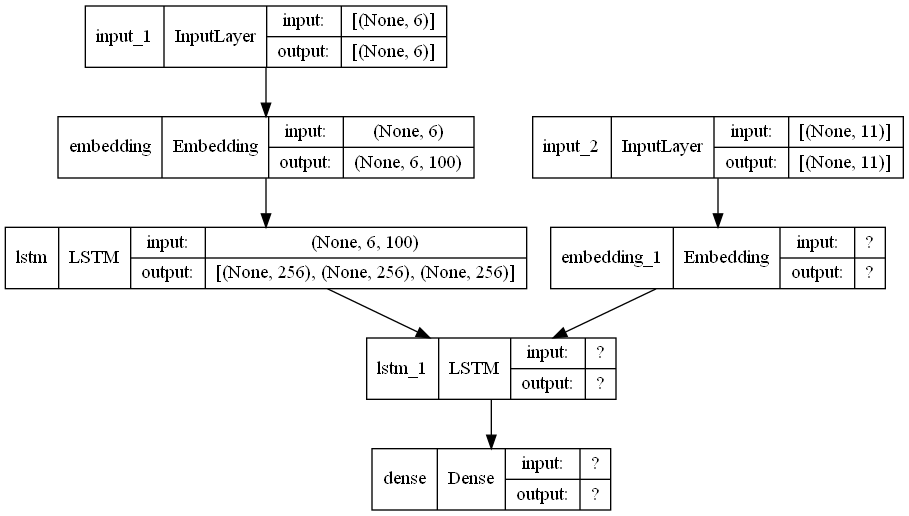

In [167]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [71]:
from nltk.translate.bleu_score import sentence_bleu

In [109]:
# for i in 
i = np.random.choice(len(test_english))
test_input_seq = test_encoder_input_sequences[i:i+1]
translation = translate_sentence(test_input_seq)
print('-')
print('Input:', i, input_sentences[i])
print('Actual Output:', output_sentences[i])
print('Response:', translation)

-
Input: 6077 i forgot that
Actual Output: das hatte ich vergessen <eos>
Response: das habe ich vergessen


In [146]:
bleu_scoring_1 = []
bleu_scoring_2 = []
bleu_scoring_3 = []
bleu_scoring_4 = []

for i in range(700,1700):
    i = np.random.choice(len(test_english))
    test_input_seq = test_encoder_input_sequences[i:i+1]
    translation = translate_sentence(test_input_seq)
    print(output_sentences[i].split()[0:-1])
    print(translation.split())

    # print(output_sentences[i])
    # print(translation)

    # reference = output_sentences[i].split()[0:-1] + ["."]
    # candidate = translation.split() + ["."]

    reference = output_sentences[i].split()[0:-1]
    candidate = translation.split()

    print(reference)
    print(candidate)

    print('Cumulative 1-gram: %f' % sentence_bleu([reference], candidate, weights=(1, 0, 0, 0)))
    print('Cumulative 2-gram: %f' % sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0)))
    print('Cumulative 3-gram: %f' % sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0)))
    if len(candidate) > 3 and len(reference) > 3:
        print('Cumulative 4-gram: %f' % sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25)))
    
    bleu_scoring_1.append(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0)))
    bleu_scoring_2.append(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0)))
    bleu_scoring_3.append(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0)))
    if len(candidate) > 3 and len(reference) > 3:
        bleu_scoring_4.append(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25)))

['tom', 'tut', 'es', 'leid']
['tom', 'tut', 'es', 'leid']
['tom', 'tut', 'es', 'leid']
['tom', 'tut', 'es', 'leid']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['ich', 'bin', 'kanadier']
['ich', 'bin', 'kanadier']
['ich', 'bin', 'kanadier']
['ich', 'bin', 'kanadier']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000


C:\Users\mateu\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


['es', 'ist', 'für', 'mich']
['das', 'ist', 'für', 'mich']
['es', 'ist', 'für', 'mich']
['das', 'ist', 'für', 'mich']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['tom', 'motzte']
['tom', 'hat', 'nicht', 'zu', 'hause']
['tom', 'motzte']
['tom', 'hat', 'nicht', 'zu', 'hause']
Cumulative 1-gram: 0.200000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['weine', 'nicht']
['nicht', 'weinen']
['weine', 'nicht']
['nicht', 'weinen']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000


C:\Users\mateu\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mateu\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


['ich', 'hatte', 'zweifel']
['ich', 'hatte', 'keine', 'angst']
['ich', 'hatte', 'zweifel']
['ich', 'hatte', 'keine', 'angst']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.408248
Cumulative 3-gram: 0.000000
['sie', 'ist', 'eine', 'zeitarbeiterin']
['sie', 'ist', 'ein']
['sie', 'ist', 'eine', 'zeitarbeiterin']
['sie', 'ist', 'ein']
Cumulative 1-gram: 0.477688
Cumulative 2-gram: 0.413690
Cumulative 3-gram: 0.000000
['denk', 'noch', 'mal', 'nach']
['es', 'noch', 'einmal']
['denk', 'noch', 'mal', 'nach']
['es', 'noch', 'einmal']
Cumulative 1-gram: 0.238844
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['du', 'beängstigst', 'mich']
['du', 'hast', 'mich', 'geschlagen']
['du', 'beängstigst', 'mich']
['du', 'hast', 'mich', 'geschlagen']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['fang', 'mich']
['fang', 'mich']
['fang', 'mich']
['fang', 'mich']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 0.000000
['fassen', '

['ich', 'lese', 'lippen']
['ich', 'lese', 'eine', 'brille']
['ich', 'lese', 'lippen']
['ich', 'lese', 'eine', 'brille']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.408248
Cumulative 3-gram: 0.000000
['wer', 'wird', 'anfangen']
['wer', 'wird', 'anfangen']
['wer', 'wird', 'anfangen']
['wer', 'wird', 'anfangen']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['schmeck', 'das']
['mach', 'das', 'mal', 'ein', 'bisschen']
['schmeck', 'das']
['mach', 'das', 'mal', 'ein', 'bisschen']
Cumulative 1-gram: 0.200000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['sie', 'haben', 'es', 'repariert']
['sie', 'haben', 'es', 'geschafft']
['sie', 'haben', 'es', 'repariert']
['sie', 'haben', 'es', 'geschafft']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['lies', 'es', 'vor']
['lies', 'es', 'vor']
['lies', 'es', 'vor']
['lies', 'es', 'vor']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.0

['so', 'ist', 'das', 'leben']
['das', 'ist', 'leben']
['so', 'ist', 'das', 'leben']
['das', 'ist', 'leben']
Cumulative 1-gram: 0.716531
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['sie', 'weigerten', 'sich']
['sie', 'haben', 'sich', 'nicht', 'hasse']
['sie', 'weigerten', 'sich']
['sie', 'haben', 'sich', 'nicht', 'hasse']
Cumulative 1-gram: 0.400000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['suche', 'eines', 'aus']
['nimm', 'eine', 'eins']
['suche', 'eines', 'aus']
['nimm', 'eine', 'eins']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['iss', 'es']
['iss', 'das']
['iss', 'es']
['iss', 'das']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['sie', 'schliefen']
['sie', 'haben', 'sich', 'gegessen']
['sie', 'schliefen']
['sie', 'haben', 'sich', 'gegessen']
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['versuch’s', 'einmal', 'und', 'sing']
['versuch', '

['gib', 'dein', 'bestes']
['gib', 'dein', 'bestes']
['gib', 'dein', 'bestes']
['gib', 'dein', 'bestes']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['ich', 'habe', 'geschummelt']
['ich', 'habe', 'betrogen']
['ich', 'habe', 'geschummelt']
['ich', 'habe', 'betrogen']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['ich', 'bin', 'kein', 'fachmann']
['ich', 'bin', 'kein', 'arzt']
['ich', 'bin', 'kein', 'fachmann']
['ich', 'bin', 'kein', 'arzt']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['wer', 'hat', 'das', 'getan']
['wer', 'hat', 'das', 'getan']
['wer', 'hat', 'das', 'getan']
['wer', 'hat', 'das', 'getan']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['seid', 'ihr', 'neu']
['bist', 'du', 'neu']
['seid', 'ihr', 'neu']
['bist', 'du', 'neu']
Cumulative 1-gram: 0.333333
Cumulative 2

['ich', 'werde', 'nicht', 'kommen']
['ich', 'werde', 'nicht', 'kommen']
['ich', 'werde', 'nicht', 'kommen']
['ich', 'werde', 'nicht', 'kommen']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['hunde', 'machen', 'freude']
['hunde', 'machen', 'spaß']
['hunde', 'machen', 'freude']
['hunde', 'machen', 'spaß']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['rate', 'mal', 'wer', 'gewonnen', 'hat']
['wer', 'hat', 'gewonnen']
['rate', 'mal', 'wer', 'gewonnen', 'hat']
['wer', 'hat', 'gewonnen']
Cumulative 1-gram: 0.513417
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'habe', 'tom', 'gefragt']
['ich', 'habe', 'tom', 'gefragt']
['ich', 'habe', 'tom', 'gefragt']
['ich', 'habe', 'tom', 'gefragt']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['folge', 'uns']
['uns', 'mit', 'uns', 'in', 'der', 'uns', 'ruhe']
['folge

['ich', 'bin', 'die', 'letzte']
['ich', 'bin', 'der', 'ziemlich']
['ich', 'bin', 'die', 'letzte']
['ich', 'bin', 'der', 'ziemlich']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.408248
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['sie', 'haben', 'es', 'in', 'ordnung', 'gebracht']
['sie', 'haben', 'es', 'geschafft']
['sie', 'haben', 'es', 'in', 'ordnung', 'gebracht']
['sie', 'haben', 'es', 'geschafft']
Cumulative 1-gram: 0.454898
Cumulative 2-gram: 0.428882
Cumulative 3-gram: 0.383860
Cumulative 4-gram: 0.000000
['das', 'kannst', 'du', 'knicken']
['vergiss', 'es']
['das', 'kannst', 'du', 'knicken']
['vergiss', 'es']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['wir', 'waren', 'uns', 'einig']
['wir', 'sind', 'einverstanden']
['wir', 'waren', 'uns', 'einig']
['wir', 'sind', 'einverstanden']
Cumulative 1-gram: 0.238844
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['keiner', 'wusste', 'es']
['niemand', 'wusste', 'es']
['keine

['mach', 'es', 'für', 'tom']
['mach', 'es', 'für', 'tom']
['mach', 'es', 'für', 'tom']
['mach', 'es', 'für', 'tom']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['ich', 'habe', 'es']
['ich', 'habe', 'es']
['ich', 'habe', 'es']
['ich', 'habe', 'es']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['tu', 'was', 'ich', 'sage']
['tu', 'was', 'ich', 'sage']
['tu', 'was', 'ich', 'sage']
['tu', 'was', 'ich', 'sage']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['gott', 'segne', 'dich']
['gott', 'gott', 'dich']
['gott', 'segne', 'dich']
['gott', 'gott', 'dich']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['er', 'ist', 'hier']
['er', 'ist', 'hier']
['er', 'ist', 'hier']
['er', 'ist', 'hier']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['nimm', 'nur'

['tom', 'wurde', 'von', 'einem', 'auto', 'angefahren']
['ein', 'auto', 'wurde', 'tom']
['tom', 'wurde', 'von', 'einem', 'auto', 'angefahren']
['ein', 'auto', 'wurde', 'tom']
Cumulative 1-gram: 0.454898
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['ich', 'gehe', 'zu', 'fuß']
['ich', 'werde', 'zu', 'fuß', 'gehen']
['ich', 'gehe', 'zu', 'fuß']
['ich', 'werde', 'zu', 'fuß', 'gehen']
Cumulative 1-gram: 0.600000
Cumulative 2-gram: 0.387298
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['ich', 'bin', 'so', 'doof']
['ich', 'bin', 'so', 'dumm']
['ich', 'bin', 'so', 'doof']
['ich', 'bin', 'so', 'dumm']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['habt', 'ihr', 'euch', 'verirrt']
['hast', 'du', 'dich', 'verirrt']
['habt', 'ihr', 'euch', 'verirrt']
['hast', 'du', 'dich', 'verirrt']
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gra

['tom', 'hatte', 'etwas', 'einzuwenden']
['tom', 'hat', 'sich', 'zu', 'schien', 'den', 'mund']
['tom', 'hatte', 'etwas', 'einzuwenden']
['tom', 'hat', 'sich', 'zu', 'schien', 'den', 'mund']
Cumulative 1-gram: 0.142857
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['ganz', 'toll']
['das', 'ist', 'großartig']
['ganz', 'toll']
['das', 'ist', 'großartig']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['bringt', 'es', 'her']
['bring', 'es', 'her']
['bringt', 'es', 'her']
['bring', 'es', 'her']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['tom', 'wusste', 'es']
['tom', 'wusste', 'es']
['tom', 'wusste', 'es']
['tom', 'wusste', 'es']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['nichts', 'sagen']
['sag', 'nichts']
['nichts', 'sagen']
['sag', 'nichts']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['blei

['tom', 'rannte']
['tom', 'rannte']
['tom', 'rannte']
['tom', 'rannte']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 0.000000
['wir', 'sind', 'zeitig']
['wir', 'sind', 'früh']
['wir', 'sind', 'zeitig']
['wir', 'sind', 'früh']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['mache', 'es']
['mach', 'es']
['mache', 'es']
['mach', 'es']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'kann', 'nicht', 'fliegen']
['ich', 'kann', 'nicht', 'fliegen']
['ich', 'kann', 'nicht', 'fliegen']
['ich', 'kann', 'nicht', 'fliegen']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['ich', 'weinte']
['ich', 'habe', 'geweint']
['ich', 'weinte']
['ich', 'habe', 'geweint']
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['wir', 'schwammen']
['wir', 'sind']
['wir', 'schwammen']
['wir', 'sind']
Cumulative

['ich', 'kann', 'französisch']
['ich', 'weiß', 'französisch']
['ich', 'kann', 'französisch']
['ich', 'weiß', 'französisch']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['thomas', 'hat', 'geantwortet']
['tom', 'hat', 'es', 'geschafft']
['thomas', 'hat', 'geantwortet']
['tom', 'hat', 'es', 'geschafft']
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'habe', 'mich', 'erholt']
['ich', 'habe', 'mich', 'verloren']
['ich', 'habe', 'mich', 'erholt']
['ich', 'habe', 'mich', 'verloren']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['ich', 'brauche', 'farbe']
['ich', 'brauche', 'eine']
['ich', 'brauche', 'farbe']
['ich', 'brauche', 'eine']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['niemand', 'ist', 'zu', 'hause']
['niemand', 'ist', 'zu', 'hause']
['niemand', 'ist', 'zu', 'hause']
['niemand', 'ist', 'zu', '

['ich', 'drückte', 'sie']
['ich', 'habe', 'sie', 'ihr']
['ich', 'drückte', 'sie']
['ich', 'habe', 'sie', 'ihr']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['alle', 'aufstehen']
['alle', 'sind', 'alle']
['alle', 'aufstehen']
['alle', 'sind', 'alle']
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['verzieh', 'dich']
['geh', 'ein', 'pferd']
['verzieh', 'dich']
['geh', 'ein', 'pferd']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['wie', 'kann', 'das', 'sein']
['wie', 'kann', 'das', 'sein']
['wie', 'kann', 'das', 'sein']
['wie', 'kann', 'das', 'sein']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['mach', 'es', 'aus']
['mach', 'es', 'aus']
['mach', 'es', 'aus']
['mach', 'es', 'aus']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['ich', 'habe', 'schmerzen']
['ich', 'habe', '

['sind', 'sie', 'ein', 'fan']
['bist', 'du', 'ein', 'wein']
['sind', 'sie', 'ein', 'fan']
['bist', 'du', 'ein', 'wein']
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['ich', 'bin', 'fett']
['ich', 'bin', 'dick']
['ich', 'bin', 'fett']
['ich', 'bin', 'dick']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['ihr', 'seid', 'zäh']
['du', 'bist', 'besorgt']
['ihr', 'seid', 'zäh']
['du', 'bist', 'besorgt']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'werde', 'es', 'lesen']
['ich', 'werde', 'es', 'lesen']
['ich', 'werde', 'es', 'lesen']
['ich', 'werde', 'es', 'lesen']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['er', 'lügt']
['er', 'lügt']
['er', 'lügt']
['er', 'lügt']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 0.000000
['tom', 'ist', 'dick']
['t

['sie', 'liebt', 'ihn']
['sie', 'mag', 'ihn']
['sie', 'liebt', 'ihn']
['sie', 'mag', 'ihn']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'habe', 'gegähnt']
['ich', 'habe', 'mich']
['ich', 'habe', 'gegähnt']
['ich', 'habe', 'mich']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['ihr', 'könnt', 'es', 'versuchen']
['du', 'kannst', 'es', 'versuchen']
['ihr', 'könnt', 'es', 'versuchen']
['du', 'kannst', 'es', 'versuchen']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.408248
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['übernimm', 'du']
['nimm', 'den']
['übernimm', 'du']
['nimm', 'den']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ignoriert', 'sie']
['sie', 'dir', 'nichts']
['ignoriert', 'sie']
['sie', 'dir', 'nichts']
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'werde', 'zu', 'fuß', 'gehen']
['ich', 'werd

['hör', 'auf', 'zu', 'drängeln']
['hör', 'auf', 'zu', 'rennen']
['hör', 'auf', 'zu', 'drängeln']
['hör', 'auf', 'zu', 'rennen']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['fangen', 'sie', 'noch', 'mal', 'von', 'vorne', 'an']
['fang', 'an', 'noch', 'den', 'tasse']
['fangen', 'sie', 'noch', 'mal', 'von', 'vorne', 'an']
['fang', 'an', 'noch', 'den', 'tasse']
Cumulative 1-gram: 0.268128
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['da', 'fang']
['da', 'fangen', 'sie']
['da', 'fang']
['da', 'fangen', 'sie']
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['wir', 'werden', 'es', 'verstehen']
['wir', 'werden', 'es', 'tun']
['wir', 'werden', 'es', 'verstehen']
['wir', 'werden', 'es', 'tun']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['ich', 'bin', 'schwach']
['ich', 'bin', 'schwach'

['ich', 'gehe', 'immer', 'zu', 'fuß']
['ich', 'gehe', 'zu', 'fuß']
['ich', 'gehe', 'immer', 'zu', 'fuß']
['ich', 'gehe', 'zu', 'fuß']
Cumulative 1-gram: 0.778801
Cumulative 2-gram: 0.635888
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['tom', 'ist', 'schüchtern']
['tom', 'ist', 'schüchtern']
['tom', 'ist', 'schüchtern']
['tom', 'ist', 'schüchtern']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['bleibt', 'ruhig']
['bleib', 'ruhig']
['bleibt', 'ruhig']
['bleib', 'ruhig']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'fühle', 'mich', 'schwach']
['ich', 'fühle', 'mich', 'ziemlich']
['ich', 'fühle', 'mich', 'schwach']
['ich', 'fühle', 'mich', 'ziemlich']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['das', 'ist', 'ein', 'buch']
['das', 'ist', 'ein', 'buch']
['das', 'ist', 'ein', 'buch']
['das', 'ist', 'ein', 'buch']
Cumulative 1-g

Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['untergliedere', 'das']
['mach', 'es', 'auf']
['untergliedere', 'das']
['mach', 'es', 'auf']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['darf', 'ich', 'es', 'versuchen']
['kann', 'ich', 'es', 'versuchen']
['darf', 'ich', 'es', 'versuchen']
['kann', 'ich', 'es', 'versuchen']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['ich', 'schwimme', 'nie']
['ich', 'gehe', 'nie', 'schwimmen']
['ich', 'schwimme', 'nie']
['ich', 'gehe', 'nie', 'schwimmen']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'mag', 'mathematik']
['ich', 'liebe', 'die', 'arbeit']
['ich', 'mag', 'mathematik']
['ich', 'liebe', 'die', 'arbeit']
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['hol', 'das', 'buch']
['hol', 'das', 'buch']
['hol', 'das', 'buch

['ich', 'bekam', 'es', 'mit', 'der', 'angst', 'zu', 'tun']
['ich', 'habe', 'angst']
['ich', 'bekam', 'es', 'mit', 'der', 'angst', 'zu', 'tun']
['ich', 'habe', 'angst']
Cumulative 1-gram: 0.125917
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['da', 'ist', 'er', 'ja']
['da', 'ist', 'er']
['da', 'ist', 'er', 'ja']
['da', 'ist', 'er']
Cumulative 1-gram: 0.716531
Cumulative 2-gram: 0.716531
Cumulative 3-gram: 0.716531
['ich', 'liebe', 'sie']
['ich', 'liebe', 'sie']
['ich', 'liebe', 'sie']
['ich', 'liebe', 'sie']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['liebe', 'macht', 'blind']
['liebe', 'ist', 'blind']
['liebe', 'macht', 'blind']
['liebe', 'ist', 'blind']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['es', 'ist', 'zeit', 'fürs', 'bett']
['es', 'ist', 'zeit']
['es', 'ist', 'zeit', 'fürs', 'bett']
['es', 'ist', 'zeit']
Cumulative 1-gram: 0.513417
Cumulative 2-gram: 0.513417
Cumulative 3-gram: 0.513

['komm', 'näher']
['kommen', 'sie']
['komm', 'näher']
['kommen', 'sie']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ersetze', 'es']
['hat', 'es', 'dir', 'gemacht']
['ersetze', 'es']
['hat', 'es', 'dir', 'gemacht']
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ihr', 'seid', 'gewitzt']
['du', 'bist', 'lustig']
['ihr', 'seid', 'gewitzt']
['du', 'bist', 'lustig']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['sei', 'artig']
['sei', 'ein', 'mann']
['sei', 'artig']
['sei', 'ein', 'mann']
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'habe', 'bargeld']
['ich', 'habe', 'geld']
['ich', 'habe', 'bargeld']
['ich', 'habe', 'geld']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['machs', 'gut']
['nimm', 'dich', 'auf']
['machs', 'gut']
['nimm', 'dich', 'auf']
Cumulative 1-gram: 0.000000
Cumulative 2

['schau', 'uns', 'an']
['schau', 'uns', 'an']
['schau', 'uns', 'an']
['schau', 'uns', 'an']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['schlage', 'tom']
['niemand', 'tom']
['schlage', 'tom']
['niemand', 'tom']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['lest', 'das', 'jetzt']
['lies', 'das', 'jetzt']
['lest', 'das', 'jetzt']
['lies', 'das', 'jetzt']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['das', 'stimmt', 'nicht']
['das', 'ist', 'nicht', 'aus']
['das', 'stimmt', 'nicht']
['das', 'ist', 'nicht', 'aus']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['vergesst', 'mich']
['vergiss', 'mich']
['vergesst', 'mich']
['vergiss', 'mich']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'las']
['ich', 'habe', 'am', 'lesen']
['ich', 'las']
['ich', 'habe', 'am', 'lesen']
Cumulative 1-gram: 0.2

['können', 'wir', 'kommen']
['können', 'wir', 'kommen']
['können', 'wir', 'kommen']
['können', 'wir', 'kommen']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['tom', 'sei', 'tot']
['tom', 'war', 'tot']
['tom', 'sei', 'tot']
['tom', 'war', 'tot']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['spuck', 'es', 'aus']
['mach', 'es', 'aus']
['spuck', 'es', 'aus']
['mach', 'es', 'aus']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['keiner', 'wusste', 'es']
['niemand', 'wusste', 'es']
['keiner', 'wusste', 'es']
['niemand', 'wusste', 'es']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['ich', 'habe', 'eine', 'kuh']
['ich', 'habe', 'einen', 'verrückt']
['ich', 'habe', 'eine', 'kuh']
['ich', 'habe', 'einen', 'verrückt']
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.408248
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['niederlegen']


['tom', 'darf', 'singen']
['tom', 'darf', 'singen']
['tom', 'darf', 'singen']
['tom', 'darf', 'singen']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['ich', 'will', 'meine', 'mutter']
['ich', 'will', 'meine', 'kinder']
['ich', 'will', 'meine', 'mutter']
['ich', 'will', 'meine', 'kinder']
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.707107
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.000000
['mathe', 'ist', 'schwer']
['glück', 'ist', 'schwer']
['mathe', 'ist', 'schwer']
['glück', 'ist', 'schwer']
Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.577350
Cumulative 3-gram: 0.000000
['den', 'kannst', 'du', 'ruhig', 'behalten']
['die', 'kannst', 'du', 'ruhig', 'behalten']
['den', 'kannst', 'du', 'ruhig', 'behalten']
['die', 'kannst', 'du', 'ruhig', 'behalten']
Cumulative 1-gram: 0.800000
Cumulative 2-gram: 0.774597
Cumulative 3-gram: 0.739060
Cumulative 4-gram: 0.668740
['thomas', 'fing', 'an']
['thomas', 'fing', 'an']
['thomas', 'fing', 'an']
[

['das', 'stimmt']
['das', 'ist', 'wahr']
['das', 'stimmt']
['das', 'ist', 'wahr']
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'bin', 'der', 'beste']
['ich', 'bin', 'der', 'beste']
['ich', 'bin', 'der', 'beste']
['ich', 'bin', 'der', 'beste']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['was', 'ist', 'das', 'problem']
['was', 'ist', 'was', 'ich', 'ein', 'tun']
['was', 'ist', 'das', 'problem']
['was', 'ist', 'was', 'ich', 'ein', 'tun']
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.258199
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
['ich', 'kann', 'nicht', 'schlafen']
['ich', 'kann', 'nicht', 'schlafen']
['ich', 'kann', 'nicht', 'schlafen']
['ich', 'kann', 'nicht', 'schlafen']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['ich', 'bin', 'blind']
['ich', 'bin', 'blind']
['ich', 'bin', 'blind']
['

['es', 'wird', 'gut', 'gehen']
['es', 'wird', 'gut', 'gehen']
['es', 'wird', 'gut', 'gehen']
['es', 'wird', 'gut', 'gehen']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['es', 'ist', 'zu', 'hart']
['es', 'ist', 'zu', 'hart']
['es', 'ist', 'zu', 'hart']
['es', 'ist', 'zu', 'hart']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['so', 'etwas', 'passiert', 'nun', 'mal']
['was', 'passiert', 'vor']
['so', 'etwas', 'passiert', 'nun', 'mal']
['was', 'passiert', 'vor']
Cumulative 1-gram: 0.171139
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['tom', 'fühlte', 'sich', 'schlecht']
['tom', 'fühlte', 'sich', 'schlecht']
['tom', 'fühlte', 'sich', 'schlecht']
['tom', 'fühlte', 'sich', 'schlecht']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
['wir', 'kennen', 'dich']
['wir', 'kennen', 'dich']
['

['wir', 'zögerten']
['wir', 'haben', 'keine', 'angst']
['wir', 'zögerten']
['wir', 'haben', 'keine', 'angst']
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
['ich', 'mag', 'diese']
['ich', 'mag', 'diese']
['ich', 'mag', 'diese']
['ich', 'mag', 'diese']
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
['repariere', 'das', 'dach']
['mach', 'die', 'tür', 'auf']
['repariere', 'das', 'dach']
['mach', 'die', 'tür', 'auf']
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000


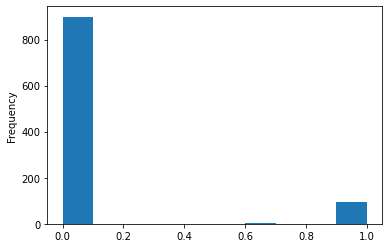

In [166]:
bleu_scoring_4.sort()

# bleu_scoring_1

pd.Series(bleu_scoring_4).plot(kind='hist') # `bins` defines the start and end points of bins
 
plt.savefig('saved_figure_4')

# pd.Series(bleu_scoring_1).plot(kind='bar')

In [150]:
df1 = pd.Series(bleu_scoring_1).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
 
 
# printing result
print(f"The list frequency of elements is :\n {df1.to_string(index=False)}" )

import statistics as st

st.mean(bleu_scoring_1)

The list frequency of elements is :
  Element  Frequency
0.000000         84
0.111565          1
0.122626          1
0.125917          1
0.142857          2
0.151633          1
0.163746          1
0.166667          2
0.171139          3
0.183940          3
0.194700          2
0.200000         14
0.236183          1
0.238844         18
0.245253          1
0.250000         37
0.268128          1
0.303265         15
0.333333         93
0.342278          4
0.367879          4
0.389400          3
0.400000         20
0.454898          2
0.477688         18
0.491238          1
0.500000        133
0.513417          3
0.584101          6
0.600000          9
0.606531          3
0.666667        132
0.705401          1
0.716531         12
0.750000         68
0.778801          5
0.800000          5
0.857143          1
1.000000        289


0.6022245160246587

In [160]:
df1 = pd.Series(bleu_scoring_2).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
 
 
# printing result
print(f"The list frequency of elements is :\n {df1.to_string(index=False)}" )

import statistics as st

st.mean(bleu_scoring_2)

The list frequency of elements is :
       Element  Frequency
 0.000000e+00         84
2.300395e-155          1
2.353507e-155          1
3.168233e-155          1
3.880277e-155          3
4.421625e-155          3
4.523712e-155          1
5.461706e-155          1
5.487540e-155          4
5.637976e-155          2
5.808562e-155          2
6.089710e-155          2
6.170875e-155         18
6.253122e-155          3
6.323892e-155          1
6.397495e-155         15
6.670943e-155         14
7.458341e-155         37
7.658480e-155          1
7.835300e-155          1
8.612150e-155         91
8.726935e-155          3
9.047425e-155          1
9.434138e-155         13
9.459952e-155          1
1.006072e-154          1
1.054769e-154         73
1.068827e-154          1
1.217942e-154         27
1.291823e-154          1
1.491668e-154          3
 1.928428e-01          1
 2.041241e-01          1
 2.123953e-01          1
 2.581989e-01          1
 2.964215e-01          1
 3.162278e-01          8
 3.179441e-01

0.45004101469985736

In [161]:
df1 = pd.Series(bleu_scoring_3).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
 
 
# printing result
print(f"The list frequency of elements is :\n {df1.to_string(index=False)}" )

import statistics as st

st.mean(bleu_scoring_3)

The list frequency of elements is :
       Element  Frequency
 0.000000e+00         84
1.469986e-204          1
1.579304e-204          1
2.277733e-204          1
2.603832e-204          3
3.178833e-204          3
3.273052e-204          4
3.415233e-204          1
3.995835e-204          3
4.282805e-204          1
4.292993e-204         15
4.385245e-204          2
4.407673e-204          1
4.436418e-204         18
4.567911e-204          1
4.681284e-204          2
4.907613e-204          1
4.925580e-204          2
5.231030e-204         14
5.396350e-204          1
5.576637e-204          3
5.630767e-204         37
6.154295e-204          1
6.191520e-204         91
6.301500e-204          1
6.375034e-204          1
6.575475e-204         13
7.077949e-204         73
7.782824e-204         27
8.091286e-204          1
8.897076e-204          3
7.636233e-103          1
7.800328e-103          1
1.045091e-102          1
1.065722e-102          1
1.220432e-102          1
1.286057e-102          3
1.395159e-102

0.3166016681412957

In [153]:
df1 = pd.Series(bleu_scoring_3).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
 
 
# printing result
print(f"The list frequency of elements is :\n {df1.to_string(index=False)}" )

import statistics as st

st.mean(bleu_scoring_3)

The list frequency of elements is :
       Element  Frequency
 0.000000e+00         84
1.469986e-204          1
1.579304e-204          1
2.277733e-204          1
2.603832e-204          3
3.178833e-204          3
3.273052e-204          4
3.415233e-204          1
3.995835e-204          3
4.282805e-204          1
4.292993e-204         15
4.385245e-204          2
4.407673e-204          1
4.436418e-204         18
4.567911e-204          1
4.681284e-204          2
4.907613e-204          1
4.925580e-204          2
5.231030e-204         14
5.396350e-204          1
5.576637e-204          3
5.630767e-204         37
6.154295e-204          1
6.191520e-204         91
6.301500e-204          1
6.375034e-204          1
6.575475e-204         13
7.077949e-204         73
7.782824e-204         27
8.091286e-204          1
8.897076e-204          3
7.636233e-103          1
7.800328e-103          1
1.045091e-102          1
1.065722e-102          1
1.220432e-102          1
1.286057e-102          3
1.395159e-102

0.3166016681412957

In [163]:
df1 = pd.Series(bleu_scoring_4).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
 
 
# printing result
print(f"The list frequency of elements is :\n {df1.to_string(index=False)}" )

import statistics as st

st.mean(bleu_scoring_4)

The list frequency of elements is :
       Element  Frequency
 0.000000e+00         84
3.109291e-232          1
3.418292e-232          1
5.092529e-232          1
5.635810e-232          3
6.702145e-232          4
7.107197e-232          3
7.813508e-232          1
8.451929e-232          3
9.291880e-232         15
9.353597e-232          1
9.711930e-232          1
9.918892e-232         18
9.974863e-232          1
1.003274e-231          2
1.028316e-231          1
1.104997e-231          1
1.120041e-231          2
1.164047e-231          2
1.179562e-231          3
1.218332e-231         14
1.288230e-231         37
1.305400e-231          1
1.312766e-231          1
1.320383e-231          1
1.384293e-231         91
1.448850e-231         13
1.531972e-231         73
1.646211e-231         27
1.695406e-231          1
1.821832e-231          3
4.169629e-155          1
4.502083e-155          1
5.819186e-155          1
6.739372e-155          1
7.422681e-155          3
7.579654e-155          1
8.121328e-155

0.0995941284095709

In [ ]:
df1 = pd.Series(bleu_scoring_4).value_counts().sort_index().reset_index().reset_index(drop=True)
df1.columns = ['Element', 'Frequency']
 
 
# printing result
print(f"The list frequency of elements is :\n {df1.to_string(index=False)}" )

import statistics as st

st.mean(bleu_scoring_4)

In [ ]:
score = sentence_bleu([['where', 'are', 'the', 'economic', 'network']], ['where', 'are', 'the', 'economic', 'network'])
print(score)

In [ ]:
# Create a list of lists in which each list contains words of a sentence 
# (here split() function will separate the words from the sentence)
gvn_data = [
    'hello this is btechgeeks'.split(),
    'good morning btechgeeks'.split(),
    'welcome to btechgeeks'.split()
]
# Take some random sentence and get all the words of it using the split() function
testd_lst1 = 'good is btechgeeks'.split()
# Pass the above list of lists and the above tested list for the sentence_bleu() function
# and print the BLEU score of it.
print('The above tested list1 BLEU score= ',sentence_bleu(gvn_data, testd_lst1))
# Similarly, do the same for the other.
# (here both the data and tested list are fully matched. hence it returns 1 ) 
testd_lst2 = 'hello this is btechgeeks'.split()
print('The above tested list2 BLEU score= ', sentence_bleu(gvn_data, testd_lst2))

In [ ]:
# Saving testing to Pickle
# with open('filename.pkl', 'wb') as handle:
#     pickle.dump(translation_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
pickle_loader = open("filename.pkl", "rb")

trying_list = pickle.load(pickle_loader)